In [1]:
!pip install livelossplot -q

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from torch.nn import DataParallel
from torchvision.models import efficientnet_v2_s
from torchvision.models import EfficientNet_V2_S_Weights
from torch import optim

from collections import OrderedDict

from livelossplot import PlotLosses
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Hyperparameter to be used later
BASE_DIR = "/kaggle/input/alzheimer-roboflow-classification-dataset"

TRAIN_DIR = BASE_DIR + "/train"
VAL_DIR = BASE_DIR + "/valid"
TEST_DIR = BASE_DIR + "/test"

BATCH_SIZE = 128
LR = 5e-4
WEIGHT_DECAY = 0.2
LR_DECAY = 0.5
DROPOUT = 0.3
EPOCHS = 50

In [4]:
def compute_mean_and_std(folder):
    """
    Compute per-channel mean and std of the dataset (to be used in transforms.Normalize())
    """

    cache_file = "mean_and_std.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std")
        d = torch.load(cache_file)

        return d["mean"], d["std"]

    ds = datasets.ImageFolder(
        folder, transform=transforms.Compose([transforms.ToTensor()])
    )
    dl = torch.utils.data.DataLoader(
        ds, batch_size=1, num_workers=0
    )

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean"):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(dl.dataset)

    var = 0.0
    npix = 0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std"):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix += images.nelement()

    std = torch.sqrt(var / (npix / 3))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std

In [5]:
mean, std = compute_mean_and_std(TRAIN_DIR)

Computing mean:   0%|          | 0/6929 [00:00<?, ?it/s]

Computing std:   0%|          | 0/6929 [00:00<?, ?it/s]

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# Load the dataset using ImageFolder
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(VAL_DIR, transform=data_transforms['test'])
test_dataset = datasets.ImageFolder(TEST_DIR, transform=data_transforms['test'])

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
def visualize_one_batch(data_loader, max_n: int = 5):
    """
    Visualize one batch of data.

    :param data_loaders: dictionary containing data loaders
    :param max_n: maximum number of images to show
    :return: None
    """

    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Undo the normalization (for visualization purposes)
    mean, std = compute_mean_and_std(TRAIN_DIR)
    invTrans = transforms.Compose(
        [
            transforms.Normalize(mean=[0.0, 0.0, 0.0], std=1 / std),
            transforms.Normalize(mean=-mean, std=[1.0, 1.0, 1.0]),
        ]
    )

    images = invTrans(images)

    class_names = data_loader.dataset.classes  

    # Convert from BGR (the format used by pytorch) to
    # RGB (the format expected by matplotlib)
    images = torch.permute(images, (0, 2, 3, 1)).clip(0, 1)

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in range(max_n):
        ax = fig.add_subplot(1, max_n, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx])
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(class_names[labels[idx].item()])

Reusing cached mean and std


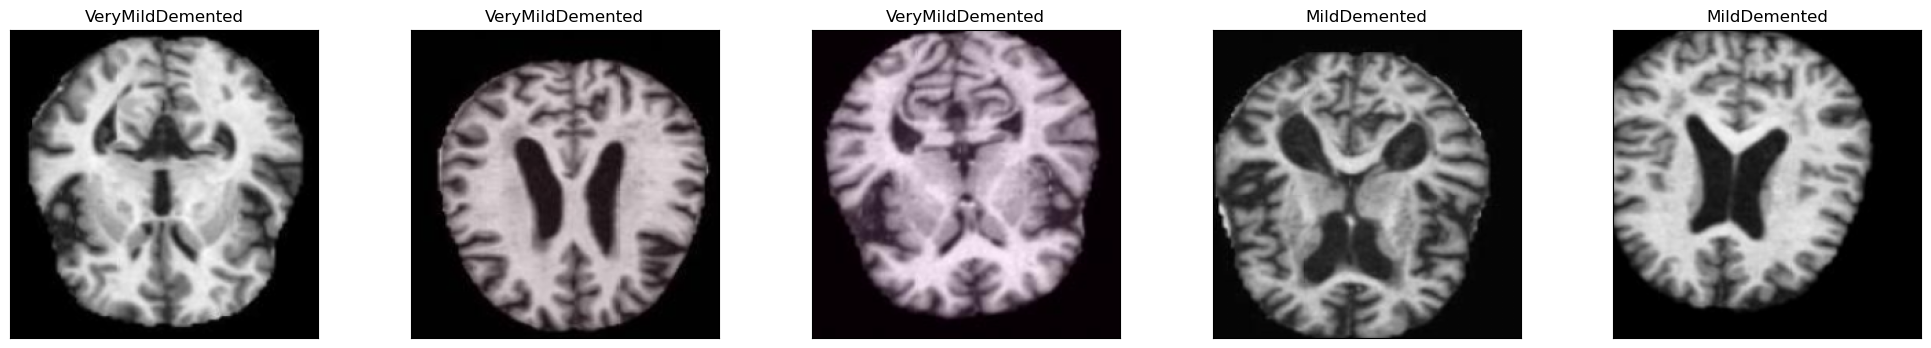

In [8]:
visualize_one_batch(train_dataloader)

In [9]:
class EfficientNetV2(nn.Module):
    def __init__(self, num_classes: int=4, dropout: float = 0.7) -> None:
        super().__init__()
        # Using swin as base model
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

        for idx, layer in enumerate(self.model.features):
            if idx > 7:
                layer.requires_grad = True
            else:
                layer.requires_grad = False

        classifier = nn.Sequential(OrderedDict([
            ('dropout1', nn.Dropout(dropout)),
            ('inputs', nn.Linear(1280, 512)),
            ('relu1', nn.ReLU()),
            ('dropout2', nn.Dropout(dropout)),
            ('outputs', nn.Linear(512, num_classes)),
        ]))

        self.model.classifier = classifier

    def forward(self, x):
        return self.model(x)

model = EfficientNetV2(num_classes=4, dropout=DROPOUT)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=1,
    last_epoch=-1
)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 86.7MB/s]


In [10]:
def fit_model(
    model, epochs, train_dataloader,
    val_dataloader, criterion,
    optimizer, scheduler, save_path):
    
    valid_loss_min = None
    
    liveloss = PlotLosses()
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    if torch.cuda.device_count() > 1:
        model = DataParallel(model)
    
    epoch_train_losses = []
    epoch_train_accs = []
    epoch_val_losses = []
    epoch_val_accs = []
    
    iters = len(train_dataloader)
    
    for epoch in range(epochs):
        logs = {}
        logs["Learning rate"] = scheduler.get_last_lr()[0]
        
        print(f"Epoch: {epoch+1}/{epochs}")
        print(f"Learning rate: {scheduler.get_last_lr()[0]}")

        model.train()
        train_loss = []
        train_acc = []
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            train_loss.append(loss.item()) 
            
            optimizer.step()
            scheduler.step(epoch + i / iters)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc.append(acc.item()) 

            if i % 10 == 0 and i != 0:
                print(f"Batch: {i:03d}/{len(train_dataloader)}", end= " | ")
                print(f"Train loss: {loss.item():.4f}", end=" | ")
                print(f"Train accuracy: {acc.item():.4f}", end=" | ")
                print()

        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_train_acc = sum(train_acc) / len(train_acc)
        
        epoch_train_losses.append(avg_train_loss)
        epoch_train_accs.append(avg_train_acc)
        
        logs["loss"] = avg_train_loss
        logs["acc"] = avg_train_acc

        print(f"Train loss: \t\t{avg_train_loss:.4f}", end=" | ")
        print(f"Train accuracy: \t{avg_train_acc:.4f}", end=" | ")
        print()

#         scheduler.step() # update lr on every batch

        model.eval()
        val_loss = []
        val_acc = []
        for i, (inputs, labels) in enumerate(val_dataloader):
            with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item()) 

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                val_acc.append(acc.item()) 

        avg_val_loss = sum(val_loss) / len(val_loss)
        avg_val_acc = sum(val_acc) / len(val_acc)
    
        epoch_val_losses.append(avg_val_loss)
        epoch_val_accs.append(avg_val_acc)
        
        if valid_loss_min is None or (
                (valid_loss_min - avg_val_loss) / valid_loss_min > 0.01
        ):
            print(f"New minimum validation loss: {avg_val_loss:.6f}. Saving model ...")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = avg_val_loss
        
        logs["val_loss"] = avg_val_loss
        logs["val_acc"] = avg_val_acc
        
        print(f"Validation loss: \t{avg_val_loss:.4f}", end=" | ")
        print(f"Validation accuracy: \t{avg_val_acc:.4f}", end=" | ")
        print()
        
        liveloss.update(logs)
        liveloss.send()
        
    history = {
        'train_loss': epoch_train_losses,
        'train_acc' : epoch_train_accs,
        'val_loss' : epoch_val_losses,
        'val_acc' : epoch_val_accs,
    }
    
    return history

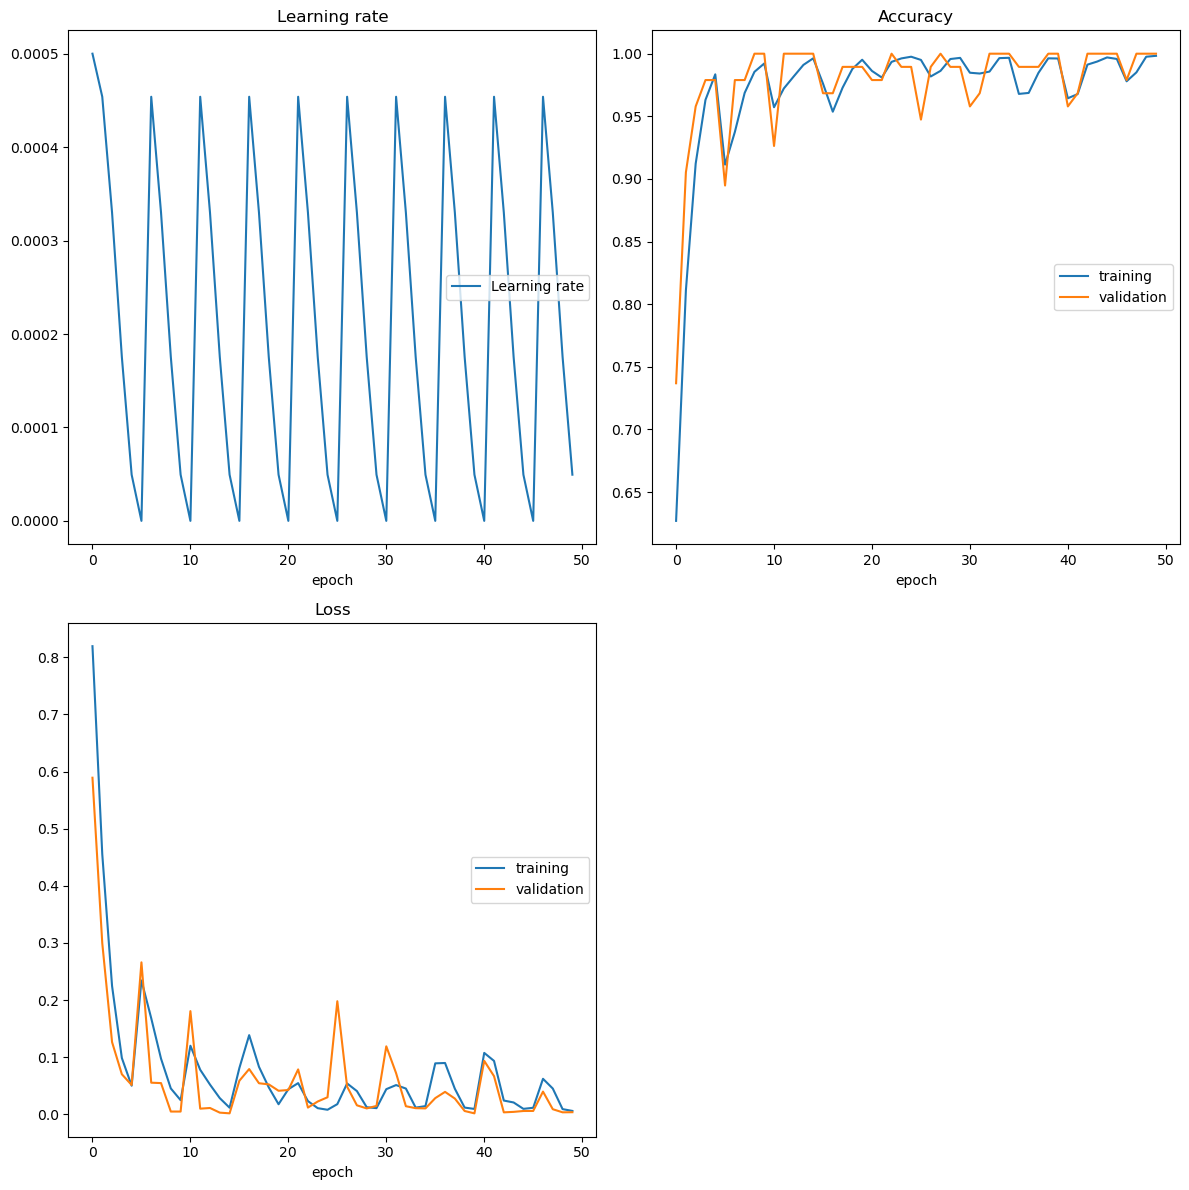

Learning rate
	Learning rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Accuracy
	training         	 (min:    0.627, max:    0.998, cur:    0.998)
	validation       	 (min:    0.737, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.006, max:    0.820, cur:    0.006)
	validation       	 (min:    0.002, max:    0.589, cur:    0.004)


In [11]:
train_history = fit_model(
    model=model,
    epochs=EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    save_path="model-checkpoint.pt"
)

In [12]:
# Load the checkpoint
checkpoint = torch.load("/kaggle/working/model-checkpoint.pt")

# Remove "module." prefix from keys
new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}

# Create an instance of the EfficientNetV2 model
model = EfficientNetV2(num_classes=4, dropout=DROPOUT)

# Load the modified state_dict into the model
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [13]:
def eval_model(model, test_dataloader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    if torch.cuda.device_count() > 1:
        model = DataParallel(model)
        
    model.eval()
    
    test_loss = []
    test_acc = []
    y_true = []
    y_pred = []

    for i, (inputs, labels) in enumerate(test_dataloader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_true.extend(labels.cpu().numpy())

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item()) 

            _, predictions = torch.max(outputs.data, 1)
            y_pred.extend(predictions.cpu().numpy())
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc.append(acc.item()) 

    avg_test_loss = sum(test_loss) / len(test_loss)
    avg_test_acc = sum(test_acc) / len(test_acc)

    print("Evaluation Results\n")
    print(f"Test loss: {avg_test_loss:.4f}", end=" | ")
    print(f"Test accuracy: {avg_test_acc:.4f}", end=" | ")
    print("\n")

    # Create a list of class names in the same order as their integer labels
    class_to_idx = train_dataset.class_to_idx
    classes = [k for k, v in class_to_idx.items()]

    # Convert integer labels to their corresponding class names
    y_true = [classes[label] for label in y_true]
    y_pred = [classes[label] for label in y_pred]

    # Print the classification report with categorical labels
    print(classification_report(y_true, y_pred, digits=4))

In [14]:
eval_model(
    model=model,
    test_dataloader=test_dataloader
)

Evaluation Results

Test loss: 0.0447 | Test accuracy: 0.9881 | 

                  precision    recall  f1-score   support

    MildDemented     0.9974    0.9987    0.9981       782
ModerateDemented     1.0000    1.0000    1.0000       526
     NonDemented     0.9751    0.9812    0.9782       799
VeryMildDemented     0.9830    0.9753    0.9791       769

        accuracy                         0.9878      2876
       macro avg     0.9889    0.9888    0.9888      2876
    weighted avg     0.9878    0.9878    0.9878      2876



In [15]:
class Predictor(nn.Module):
    def __init__(self, model, class_names, mean, std):
        super().__init__()

        self.model = model.eval()
        self.class_names = class_names

        self.transforms = nn.Sequential(
            T.Resize([256, ], antialias=True),
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize(mean.tolist(), std.tolist())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x  = self.transforms(x)
            x  = self.model(x)
            x  = F.softmax(x, dim=1)

            return x

In [16]:
class_names = train_dataloader.dataset.classes

model = model.cpu()

predictor = Predictor(model, class_names, mean, std).cpu()

scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("predictor-torchscript.pt")

In [17]:
inference = torch.jit.load("predictor-torchscript.pt")

In [18]:
# TODOS:
# - REMIND JAMES TO CLEAN UP THE TRAINING LOOP
# - WTF IS THAT
# - WHERE IS THE EDA
# - CONVERT TO TORCH SCRIPT PLS